In [1]:
import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1] + ['memn2n']))
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from bAbIDataSet_utils import bAbI
from utils import get_story_idx, matshow

In [2]:
TASK = 19
BATCH = 2
FIX_STORY = None
DEVICE = None

In [3]:
babi = bAbI()
train, valid, test = babi.splits(root='../data/QA_bAbI_tasks/en-valid-10k/', task=TASK, fix_maxlen_story=FIX_STORY,
                                 device=DEVICE)
train_loader, valid_loader, test_loader = babi.iters(train, valid, test, BATCH)
VOCAB = train.vocab

In [4]:
for b in train_loader:
    break

In [5]:
stories, queries, answers = b
stories_idx = get_story_idx(stories, 0)
print(stories_idx)
stories.size(), queries.size(), answers.size(), stories_idx.size()

tensor([[5, 4, 3, 2, 1],
        [5, 4, 3, 2, 1]])


(torch.Size([2, 5, 7]),
 torch.Size([2, 10]),
 torch.Size([2, 1]),
 torch.Size([2, 5]))

## Single Hop Implementation

In [6]:
EMBED = 10
N_HOPS = 3
MAXLEN = train.maxlen_story

### Embedding

**1. Adjacent**

In [7]:
embedding = nn.Embedding(len(VOCAB), EMBED, padding_idx=VOCAB.stoi['<pad>'])

In [8]:
embeded_a = embedding(stories)  # B, len_story, len_words, embed_size
embeded_b = embedding(queries)  # B, len_query, embed_size
embeded_a.size(), embeded_b.size()

(torch.Size([2, 10, 6, 10]), torch.Size([2, 3, 10]))

**2. RNN Like**

In [8]:
embedding_A = nn.Embedding(len(VOCAB), EMBED, padding_idx=VOCAB.stoi['<pad>'])
embedding_B = nn.Embedding(len(VOCAB), EMBED, padding_idx=VOCAB.stoi['<pad>'])
embedding_C = nn.Embedding(len(VOCAB), EMBED, padding_idx=VOCAB.stoi['<pad>'])

In [9]:
embeded_a = embedding_A(stories)  # B, len_story, len_words, embed_size
embeded_b = embedding_B(queries)  # B, len_query, embed_size
embeded_a.size(), embeded_b.size()

(torch.Size([2, 5, 7, 10]), torch.Size([2, 10, 10]))

### Position Encoding

$m_i = \sum_j l_j \odot A x_{ij}$

$l_{kj} = (1-\frac{j}{J}) - (\frac{k}{d})(1-\frac{2j}{J})$

In [10]:
# position encoding: B, len_story,, len_words(J), embed_size(d) 
B, len_story, len_words, embed_size = embeded_a.size()

In [11]:
temp = torch.ones_like(embeded_a, device='cpu')
k = temp * torch.arange(1, embed_size+1, dtype=torch.float) / embed_size
l = temp * torch.arange(1, len_words+1, dtype=torch.float).unsqueeze(1) / len_words
position = (1- l) - k * (1 - 2*l)
position_encoded = (embeded_a * position.to(embeded_a.device)).sum(2)
position_encoded.size()

torch.Size([2, 5, 10])

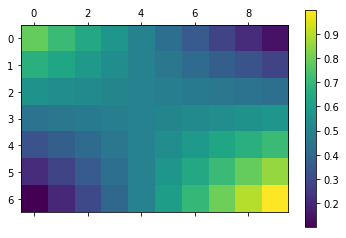

In [12]:
# one of position matrix like
matshow(position[0, 0, :].detach().numpy())

### temporal encoding

$m_i = \sum_j Ax_{ij} + T_A(i)$

Note that sentences are indexed in reverse order, reflecting their relative distance from the question so that $x_1$ is the last sentence of the story.

temporal context encoding length will be "max story + 1" because of pad stories


In [13]:
stories_idx

tensor([[5, 4, 3, 2, 1],
        [5, 4, 3, 2, 1]])

In [14]:
temporal_A = nn.Embedding(MAXLEN+1, EMBED, padding_idx=VOCAB.stoi['<pad>'])
temporal_C = nn.Embedding(MAXLEN+1, EMBED, padding_idx=VOCAB.stoi['<pad>'])
temporal_A(stories_idx).size()

torch.Size([2, 5, 10])

### memory attention

if there is no "temporal encoding" and "position encoding"

$\begin{aligned} 
m_i &= \sum_j Ax_{ij} \\
u &= \sum_j Bq_{j} \end{aligned}$

In [15]:
m = embeded_a.sum(2)  # B, len_story, len_words, embed_size > B, len_story, embed_size
u = embeded_b.sum(1)  # B, len_query, embed_size > B, embed_size
m.size(), u.size()

(torch.Size([2, 5, 10]), torch.Size([2, 10]))

$p_i = \text{softmax}(m_i \cdot u)$

If Linear Start scores don't go through softmax layer

In [16]:
LS = False
softmax_layer = nn.Softmax(dim=1)
if LS:
    p = torch.bmm(m, u.unsqueeze(2))  # B, len_story, 1
else:
    p = softmax_layer(torch.bmm(m, u.unsqueeze(2)))
embeded_c = embedding_C(stories)  # B, len_story, len_sent, embed_size
# embeded_c = embeddding(stories) : for adjacent weight style
c = embeded_c.sum(2)  # B, len_story, len_sent, embed_size > B, len_story, embed_size
c.size(), p.size()

(torch.Size([2, 5, 10]), torch.Size([2, 5, 1]))

In [17]:
print(p.detach().squeeze(2).numpy().round(3))

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


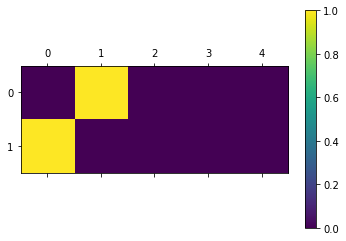

In [18]:
matshow(p.detach().squeeze(2).numpy())

### output

$o = \displaystyle\sum_i p_i c_i$

In [19]:
o = (c * p).sum(1)  # B, len_story, embed_size > B, embed_size
o.size()

torch.Size([2, 10])

$\hat{a} = \text{softmax}(W(H \cdot u + o))$

linear mapping for "rnnlike" weight style

In [20]:
linear_mapping = nn.Linear(embed_size, embed_size)  # helpful linear mapping for each hops
linear_final = nn.Linear(embed_size, len(VOCAB))

In [21]:
u_next = linear_mapping(u) + o
u_next.size()

torch.Size([2, 10])

In [22]:
a = linear_final(u_next)
a.size()

torch.Size([2, 26])

### layers for multi hops

**1. Adjacent**

In [24]:
# ModuleList will be shorter code, but for convience looking i used ModuleDict
context_modules = nn.ModuleDict([('embedding_{}_{}'.format(n, k), 
                                  nn.Embedding(len(VOCAB), EMBED, padding_idx=VOCAB.stoi['<pad>'])) \
                                for k, n in enumerate(['A', 'C']*N_HOPS)])

In [25]:
for name, mod in context_modules.items():
    idx = int(name.split('_')[-1])
    if idx == 0:
        embedding_B = mod
        print(mod.weight.size())
    elif idx % 2 == 0:
        mod.weight.data = context_modules['embedding_C_{}'.format(idx-1)].weight.data
    elif idx == (N_HOPS*2-1):
        linear_final = nn.Linear(EMBED, len(VOCAB))
        linear_final.weight.data = mod.weight.data

torch.Size([21, 10])


In [26]:
context_modules['embedding_C_1'].weight.sum() == context_modules['embedding_A_2'].weight.sum()

tensor(1, dtype=torch.uint8)

**2. RNN Like**

In [27]:
# ModuleList will be shorter code, but for convience looking i used ModuleDict
context_modules = nn.ModuleDict([('embedding_{}_{}'.format(n, k), 
                                  nn.Embedding(len(VOCAB), EMBED, padding_idx=VOCAB.stoi['<pad>'])) \
                                for k, n in enumerate(['A', 'C']*N_HOPS)])

In [28]:
# ModuleList will be shorter code, but for convience looking i used ModuleDict
for name, mod in context_modules.items():
    idx = int(name.split('_')[-1])
    if idx <= 1 :
        continue
    elif idx % 2 == 0:
        mod.weight.data = context_modules['embedding_A_0'].weight.data
    else:
        mod.weight.data = context_modules['embedding_C_1'].weight.data

# others layers
embedding_B = nn.Embedding(len(VOCAB), EMBED, padding_idx=VOCAB.stoi['<pad>'])
linear_mapping = nn.Linear(embed_size, embed_size)  # helpful linear mapping for each hops
linear_final = nn.Linear(embed_size, len(VOCAB))

In [29]:
context_modules['embedding_A_0'].weight.sum() == context_modules['embedding_A_2'].weight.sum()

tensor(1, dtype=torch.uint8)

** 3. Common: temporal encoding**

In [30]:
softmax_layer = nn.Softmax(dim=1)
temporal_modules = nn.ModuleDict([('temporal_{}'.format(n), 
                                   nn.Embedding(MAXLEN+1, EMBED, padding_idx=VOCAB.stoi['<pad>'])) \
                                  for n in ['A', 'C']])
temporal_modules

ModuleDict(
  (temporal_A): Embedding(11, 10, padding_idx=0)
  (temporal_C): Embedding(11, 10, padding_idx=0)
)

In [8]:
class MEMN2N(nn.Module):
    def __init__(self, vocab_size, embed_size, n_hops=3, weight_style='adjacent',
                 encoding_method='bow', temporal=True, maxlen_story=None, pad_idx=0):
        """
        https://arxiv.org/pdf/1503.08895.pdf
        Args:
        - vocab_size: length of vocabulary
        - embed_size: size of embedding dimension  
        - n_hops: multiple computational steps for memories
        - weight_style: 
            * 'adjacent': share all weights B = A(1) = C(1) = ... = C(K) = W^T
            * 'rnnlike': share weights 
        - encoding_method:
        - temporal:
        - maxlen_story:
        - pad_idx:
        """
        super(MEMN2N, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.n_hops = n_hops
        self.maxlen_story = maxlen_story
        self.weight_style = weight_style.lower()
        self.encoding_method = encoding_method.lower()
        self.te = temporal
        self.pad_idx = pad_idx
        
        self.layers_init()
        self.apply(self.weight_init)
        
    def layers_init(self):
        """
        two types: adjacent, rnnlike
        """
        self.context_modules = nn.ModuleDict([('embedding_{}_{}'.format(n, k), 
                                               nn.Embedding(self.vocab_size, 
                                                            self.embed_size,
                                                            padding_idx=self.pad_idx)) \
                                              for k, n in enumerate(['A', 'C']*self.n_hops)])
        # adjacent weight sharing style
        if self.weight_style == 'adjacent':
            for name, mod in self.context_modules.items():
                idx = int(name.split('_')[-1])
                if idx == 0:
                    self.embedding_B = nn.Embedding(self.vocab_size, self.embed_size, padding_idx=self.pad_idx)
                    self.embedding_B.weight.data = mod.weight.data 
                elif idx % 2 == 0:
                    mod.weight.data = self.context_modules['embedding_C_{}'.format(idx-1)].weight.data
                elif idx == (self.n_hops*2-1):
                    self.linear_final = nn.Linear(self.embed_size, self.vocab_size, bias=False)
                    self.linear_final.weight.data = mod.weight.data
            
        # rnn-like weight sharing style        
        elif self.weight_style == 'rnnlike':
            for name, mod in self.context_modules.items():
                idx = int(name.split('_')[-1])
                if idx <= 1 :
                    continue
                elif idx % 2 == 0:
                    mod.weight.data = self.context_modules['embedding_A_0'].weight.data
                else:
                    mod.weight.data = self.context_modules['embedding_C_1'].weight.data

            # others layers
            self.embedding_B = nn.Embedding(self.vocab_size, self.embed_size, padding_idx=self.pad_idx)
            self.linear_mapping = nn.Linear(self.embed_size, self.embed_size)  # inear mapping for each hops
            self.linear_final = nn.Linear(self.embed_size, self.vocab_size, bias=False)
        else:
            assert True, 'Insert "adjacent" or "rnnlike" in weight_style'
        # common
        self.softmax_layer = nn.Softmax(dim=1)
        if self.te:
            self.temporal_modules = nn.ModuleDict([('temporal_{}'.format(n), 
                                                    nn.Embedding(self.maxlen_story+1, 
                                                                 self.embed_size, 
                                                                 padding_idx=self.pad_idx)) \
                                                   for n in ['A', 'C']])
    def weight_init(self, m):
        if isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight.data, mean=0, std=0.1)
            m.weight.data[0] = 0
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight.data, mean=0, std=0.1)
            if self.weight_style == 'adjacent':
                m.weight.data[0] = 0
            if m.bias is not None:
                nn.init.zeros_(m.bias.data)
                
    def encoding2memory(self, embeded_x):
        sum_dim = 2 if embeded_x.dim() == 4 else 1  # stories sum_dim=2, queries sum_dim=1
        *_, len_words, embed_size = embeded_x.size()  # len_words=J, embed_size=d
        
        if self.encoding_method == 'bow':
            return embeded_x.sum(sum_dim)
        
        if self.encoding_method == 'pe':
            temp = torch.ones_like(embeded_x, device='cpu')
            k = temp * torch.arange(1, embed_size+1, dtype=torch.float) / embed_size
            l = temp * torch.arange(1, len_words+1, dtype=torch.float).unsqueeze(1) / len_words
            position = (1- l) - k * (1 - 2*l)
            position_encoded = (embeded_x * position.to(embeded_x.device)).sum(sum_dim)
            return position_encoded  # B, (len_story), embed_size
        
        else:
            assert True, 'Insert "bow" or "pe" in encoding_method'
            
    def forward(self, stories, queries, stories_idx, ls=False, return_p=False):
        """
        Inputs:
        - stories: B, maxlen_story(T), maxlen_words(n)
        - queries: B, maxlen_query(T_q)
        - stories_idx: B, maxlen_story(T)
        - ls: linear start
        Outputs:
        - log softmaxed score(nll loss)
        """            
        # Start Learning
        embeded_b = self.embedding_B(queries) 
        u_next = self.encoding2memory(embeded_b)  # (B, d)
        ps = []
        for k in range(self.n_hops):
            embeded_a = self.context_modules['embedding_A_{}'.format(2*k)](stories)  # (B, T, n, d)
            embeded_c = self.context_modules['embedding_C_{}'.format(2*k+1)](stories)  # (B, T, n, d)
            m = self.encoding2memory(embeded_a)  # (B, T, d)
            c = self.encoding2memory(embeded_c)  # (B, T, d)
            if self.te:
                m += self.temporal_modules['temporal_A'](stories_idx)  # (B, T, d)
                c += self.temporal_modules['temporal_C'](stories_idx)  # (B, T, d)
            if ls:
                # (B, T, d) x (B, d, 1) = (B, T, 1)
                p = torch.bmm(m, u_next.unsqueeze(2))
            else:
                p = self.softmax_layer(torch.bmm(m, u_next.unsqueeze(2)))
                ps.append(p.squeeze(2))  # [(B, T) for all hops]
            o = (c * p).sum(1)  # (B, T, d) * (B, T, 1) = (B, T, d) > (B, d)
            
            if self.weight_style == 'rnnlike':
                # (B, d) + (B, d) = (B, d)
                u_next = self.linear_mapping(u_next) + o
            else:
                u_next = u_next + o
                
        a = self.linear_final(u_next)  # (B, d) > (B, V)
        if return_p:
            return a, ps
        return torch.log_softmax(a, dim=1)  # use nll loss
        

In [10]:
memn2n = MEMN2N(vocab_size=len(VOCAB), embed_size=15, weight_style='adjacent', 
                encoding_method='bow', temporal=True, maxlen_story=train.maxlen_story,
                pad_idx=VOCAB.stoi['<pad>'])

### Check

In [11]:
memn2n.train()
memn2n.zero_grad()

In [12]:
def check_parameters(model, module_name):
    print('[layer-{}] sum of papmerters: {:.4f}'.format(module_name, 
                                                    model.context_modules[module_name].weight.sum().item()))

In [13]:
check_parameters(memn2n, 'embedding_C_1')
check_parameters(memn2n, 'embedding_A_2')

[layer-embedding_C_1] sum of papmerters: 2.2103
[layer-embedding_A_2] sum of papmerters: 2.2103


In [14]:
nll_loss = memn2n(stories, queries, stories_idx, ls=False)

https://discuss.pytorch.org/t/valueerror-cant-optimize-a-non-leaf-tensor/21751/6

In [15]:
loss_function = nn.NLLLoss(ignore_index=0, reduction='sum')
optimizer = optim.SGD(memn2n.parameters(), lr=0.01)

In [16]:
nll_loss.size()

torch.Size([2, 34])

In [19]:
loss = loss_function(nll_loss, answers.view(-1))
loss

tensor(6.8665, grad_fn=<NllLossBackward>)

In [39]:
loss.backward()
optimizer.step()

In [40]:
check_parameters(memn2n, 'embedding_C_1')
check_parameters(memn2n, 'embedding_A_2')

[layer-embedding_C_1] sum of papmerters: 3.1944
[layer-embedding_A_2] sum of papmerters: 3.1944


## Train

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 
TASK = 1
BATCH = 32
FIX_STORY = None

EMBED = 30
W_STYLE = 'adjacent'
ENC_METHOD = 'bow'
TEMPROAL = False
STEP = 10
LR = 0.01
ANNEAL = 0.5

In [4]:
babi = bAbI()
train, valid, test = babi.splits(root='../data/QA_bAbI_tasks/en-valid-10k/', 
                                 task=TASK, 
                                 fix_maxlen_story=FIX_STORY,
                                 device=DEVICE)
train_loader, valid_loader, test_loader = babi.iters(train, valid, test, BATCH)
VOCAB = train.vocab
MAXLEN = train.maxlen_story

memn2n = MEMN2N(vocab_size=len(VOCAB), embed_size=15, weight_style='rnnlike', 
                encoding_method='pe', temporal=True, maxlen_story=MAXLEN,
                pad_idx=VOCAB.stoi['<pad>']).to(DEVICE)

loss_function = nn.NLLLoss(ignore_index=VOCAB.stoi['<pad>'], reduction='sum')
optimizer = optim.SGD(memn2n.parameters(), lr=LR)
scheduler = optim.lr_scheduler.MultiStepLR(gamma=ANNEAL, milestones=[25, 50, 75], 
                                           optimizer=optimizer)

In [5]:
for step in range(STEP):
    
    scheduler.step()
    for b in train_loader:
        stories, queries, answers = b
        stories_idx = get_story_idx(stories, VOCAB.stoi['<pad>'])
        memn2n.zero_grad()
        
        nll_loss = memn2n(stories, queries, stories_idx, ls=False)
        loss = loss_function(nll_loss, answers.view(-1))
        losses.append(loss.item())
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(memn2n.parameters(), 50.0)  # gradient clipping

        optimizer.step()
        
    if step % 1 == 0:
        string = '[{}/{}] loss: {:.4f}, lr: {},'.format(step+1, STEP, np.mean(losses), scheduler.get_lr()[0])
        print(string)
        losses=[]

[1/10] loss: 60.7465, lr: 0.01,
[2/10] loss: 56.6869, lr: 0.01,
[3/10] loss: 44.6670, lr: 0.01,
[4/10] loss: 7.4042, lr: 0.01,
[5/10] loss: 0.0937, lr: 0.01,
[6/10] loss: 0.0498, lr: 0.01,
[7/10] loss: 0.0351, lr: 0.01,
[8/10] loss: 0.0273, lr: 0.01,
[9/10] loss: 0.0223, lr: 0.01,
[10/10] loss: 0.0189, lr: 0.01,
